In [1]:
import requests
import re
from bs4 import BeautifulSoup

def get_player_info(root_url, page_amount):
    players = []
    # Look through each page
    for i in range(1, page_amount + 1):
        r = requests.get(root_url+"?page={}".format(i))
        soup = BeautifulSoup(r.text)
        table = soup.find('table')

        for info in table.find_all('tr'):
            player = {}
            
            # Get Player Name 
            if info.find('a') is not None:
                player['player_name'] = info.find('a').find_all('span')[0].get_text() + ' ' + info.find('a').find_all('span')[2].get_text()
            
            # Gets stats for player
            row_info = info.find_all('td')
            if row_info != []:
                player['games'] = row_info[1].get_text()
                player['ab'] = row_info[2].get_text()
                player['h'] = row_info[4].get_text()
                player['hr'] = row_info[7].get_text()
                player['bb'] = row_info[9].get_text()
                player['so'] = row_info[10].get_text()
                player['avg'] = row_info[13].get_text()
                player['obp'] = row_info[14].get_text()
                player['slg'] = row_info[15].get_text()
            players.append(player)


    return players


# Get training set
train_set = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
train_dict = {}
for each in train_set:
    if each == '2010':
        pages = 7
    else:
        pages = 6
    train_dict[each] = get_player_info('https://www.mlb.com/stats/' + each, pages)
    
# Get test set
test_set = ['2018', '2019']
test_dict = {}
for each in test_set:
    test_dict[each] = get_player_info('https://www.mlb.com/stats/' + each, 6)

# Run on actual set
run_dict = {}
run_dict['2020'] = get_player_info('https://www.mlb.com/stats/', 6)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
# Processing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Scores
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

# Transoforms our data into a dataframe
def transform_to_df(dict_to_map):
    df_return = pd.DataFrame()
    for key in dict_to_map:
        filtered_map = [t for t in dict_to_map[key] if t]
        temp_df = pd.DataFrame(filtered_map)
        df_return = df_return.append(temp_df, ignore_index = True)
    return df_return.dropna()


# Train Dataframe of all values
train_df = transform_to_df(train_dict)
# Test Dataframe of all values
test_df = transform_to_df(test_dict)
# Run Dataframe to predict values for HomeRuns
run_df = transform_to_df(run_dict)

def evaluate_model(clf, label, perf_data, X_train, X_test, y_train, y_test):
    
    experiment_id = len(perf_data)
    for i in range(30):
        if(label == 'BayesianRidge'):
            y_train = np.ravel(y_train)
        
        _ = clf.fit(X_train, y_train)
        
        y_test_pred = clf.predict(X_test)
        perf_data[experiment_id]['model'] = label
        perf_data[experiment_id]['test_accuracy'] = clf.score(X_test, y_test)
        perf_data[experiment_id]['r2'] = r2_score(y_test, y_test_pred)
        perf_data[experiment_id]['explained_variance'] = explained_variance_score(y_test, y_test_pred)
        perf_data[experiment_id]['max_error'] = max_error(y_test, y_test_pred)
        
        experiment_id = experiment_id + 1
    return perf_data

In [3]:
from sklearn.model_selection import train_test_split
# Models
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

# Training set
x_train = train_df[['games', 'ab', 'h', 'bb', 'so', 'avg', 'obp', 'slg']]
y_train = train_df[['hr']].replace('0','1')
# Ensure that all values are numerics
y_train['hr'] = pd.to_numeric(y_train['hr'])

# Testing Set
x_test = test_df[['games', 'ab', 'h', 'bb', 'so', 'avg', 'obp', 'slg']]
y_test = test_df[['hr']].replace('0','1')
# Ensure that all values are numerics
y_test['hr'] = pd.to_numeric(y_test['hr'])

# Models to test our data with
models = {
    'DecisionTree' : tree.DecisionTreeRegressor(),
    'LinearRegression' : LinearRegression(),
    'BayesianRidge': BayesianRidge(),
    'Lasso' : linear_model.Lasso(alpha=0.1)
}

# Test our models
model_perf_data = defaultdict(dict)
for label, clf in models.items():
    _= evaluate_model(clf, label, model_perf_data, x_train, x_test, y_train, y_test)
df_perf = pd.DataFrame(model_perf_data).T

df_metrics = []
for model in df_perf.model.unique():
    y1 = df_perf[df_perf['model'] == model]['test_accuracy']
    y2 = df_perf[df_perf['model'] == model]['r2']
    y3 = df_perf[df_perf['model'] == model]['explained_variance']
    y4 = df_perf[df_perf['model'] == model]['max_error']
    
    df_metrics.append({
        'model' : model,
        'test_accuracy' : y1.mean(),
        'r2' : y2.mean(),
        'explained_variance' : y3.mean(),
        'max_error' : y4.mean(),
    })
    
pd_plot = pd.DataFrame(df_metrics)
pd_plot

,model,test_accuracy,r2,explained_variance,max_error
0,DecisionTree,0.801619,0.801619,0.803815,16.900000
1,LinearRegression,0.929429,0.929429,0.929580,7.687273
2,BayesianRidge,0.929537,0.929537,0.929676,7.684607
3,Lasso,0.871411,0.871411,0.876091,9.925746


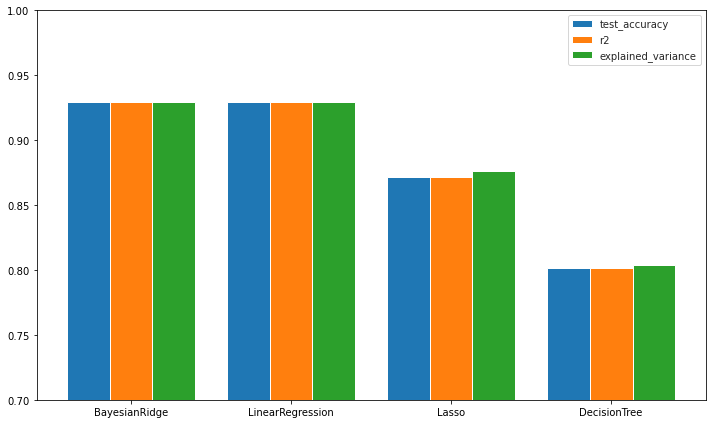

In [4]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
perf_columns = ['test_accuracy', 'r2']
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.set_style("ticks")
df = pd_plot.sort_values(by='test_accuracy', ascending=False)
df = df.reset_index()

metrics = ['test_accuracy', 'r2', 'explained_variance']
width = 1.0 / len(metrics) * 0.80
for i, col in enumerate(metrics):
    ax.bar(df.index + i * width, df[col], width)

ax.set_xticks(df.index + width)
ax.set_ylim(bottom=0.7, top=1)
_ = ax.set_xticklabels(df['model'])
ax.legend(metrics, loc='best')

fig.tight_layout()

In [5]:
# Prediction Set may need to scale for full season
x_run = run_df[['games', 'ab', 'h', 'bb', 'so', 'avg', 'obp', 'slg']]
# Scale run data for a full season
# Only 60 games were played out of a normal 162 so we need to scale our data by a factor of 2.7
for rows in x_run:
    if((rows != 'avg') and (rows != 'obp') and (rows != 'slg')):
        x_run[rows] = pd.to_numeric(x_run[rows])
        x_run[rows] = x_run[rows] * 2.7
        x_run[rows] = x_run[rows].apply(np.floor)

y_run = run_df[['hr']].replace('0','1')
# Ensure that all values are numerics
y_run['hr'] = pd.to_numeric(y_run['hr'])

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_run)
final_df = []
i = 0
for each in run_df['player_name']:
    final_df.append({
        'player_name' : each,
        'hr_prediction' : int(round(predictions[i][0]))
    })
    i+=1
final_plot = pd.DataFrame(final_df)
print(final_plot.tail(20))
final_plot = final_plot.sort_values('hr_prediction', ascending=False)
final_plot.head(5)

         player_name  hr_prediction
122    Marcus Semien             18
123       Joey Gallo             27
124      Kolten Wong             -2
125    J.P. Crawford              5
126       Nick Solak              4
127        Josh Bell             15
128     Adam Frazier             15
129   Avisail Garcia              4
130     Yuli Gurriel             18
131    Jorge Polanco              7
132   Bryan Reynolds             21
133      Jose Altuve             12
134    Erik Gonzalez             12
135    Victor Robles              5
136  Marwin Gonzalez              8
137  Eduardo Escobar             13
138      Javier Baez             22
139       Evan White             21
140  Jonathan Villar              0
141      Nicky Lopez              1


<ipython-input-5-919a304cb35b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_run[rows] = pd.to_numeric(x_run[rows])
<ipython-input-5-919a304cb35b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_run[rows] = x_run[rows] * 2.7
<ipython-input-5-919a304cb35b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

,player_name,hr_prediction
15,Luke Voit,48
4,Jose Ramirez,45
5,Mike Trout,45
8,Ronald Acuna,44
13,Wil Myers,44


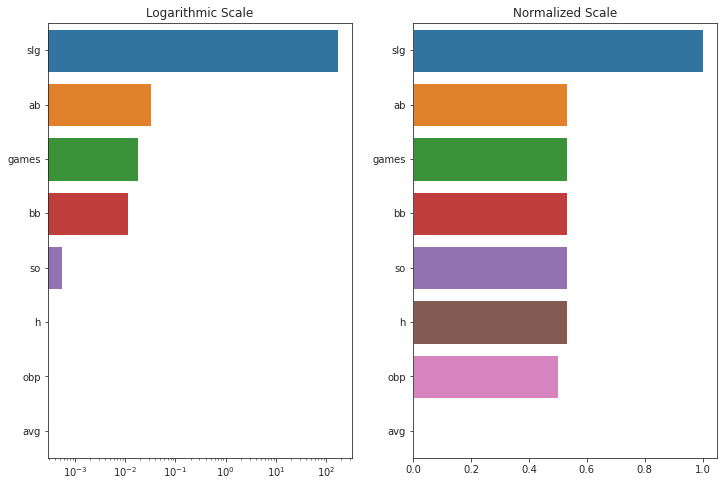

In [6]:
from sklearn.inspection import permutation_importance

clf = LinearRegression()
clf.fit(x_train,y_train)

feature_names = ['games', 'ab', 'h', 'bb', 'so', 'avg', 'obp', 'slg']

# Compute permutation_importance
permutated_importance_result = permutation_importance(clf, x_train, y_train, n_repeats=10)
# Arrange the data for plotting
feature_importance_sorted_idx = np.flip(np.argsort(clf.coef_))
s_feature_importances = pd.Series(clf.coef_[0], index=feature_names).sort_values(ascending=False)
df_permutation_importances = pd.DataFrame(permutated_importance_result.importances[feature_importance_sorted_idx].T[0], 
                                    columns=np.array(feature_names)[feature_importance_sorted_idx])

# Plot feature_importances and permutation_importance
fig, ax = plt.subplots(1, 2,figsize=(12, 8))
temp = []
for each in s_feature_importances.values:
    new_val = (each - min(s_feature_importances.values))/ (max(s_feature_importances.values)-min(s_feature_importances.values))
    temp.append(new_val)
_ = sns.barplot(x=s_feature_importances.values, y=s_feature_importances.index, ax=ax[0])
_ = ax[0].set_title('Logarithmic Scale')
_ = ax[0].set(xscale="log")
_ = ax[1].set_title('Normalized Scale')
_ = sns.barplot(x=np.array(temp), y=s_feature_importances.index, ax=ax[1])